# NLP

En este notebook se trabaja con el siguiente dataset:

https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection/

Objetivo: conocer algunas herramientas típicas del Procesamiento del Lenguaje Natural (NLP). La biblioteca fundamental que se usa es NLTK.

Nota: la mayoría de las herramientas de NLP pueden ser consideradas como parte del preprocesamiento, esto es llevar el texto a una forma que el computador pueda entender. En general, esto corresponde a una forma tipo "tabla" al estilo de los DataFrames de Pandas. Recordar que ese es siempre un primer objetivo.

Algunos pasos comunes en un NLP pipeline:
* Tokenización
* Normalización
* Eliminación de palabras redundantes
* Stemming
* Lematización
* Frecuencia de los témrinos

Lectura recomendada: [Conceptos de NLP](http://datascience.recursos.uoc.edu/es/procesamiento-del-lenguaje-natural-nlp/)

## Carga de datos

Hay que revisar en qué formato están los datos. ¿De qué se trata ese formato?¿Cómo se abre? En este caso se trabajo con un archivo JSON. Se sugiere investigar las diversas formas que hay para abrir/leer archivos JSON con Pandas.

In [2]:
import itertools

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import nltk

#Esto sirve para configurar NLTK. La primera vez puede tardar un poco
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
dataset = pd.read_json ("Sarcasm_Headlines_Dataset.json", lines = True)
dataset.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


EDA

* Forma del dataset
* Cantidad de instancias
* Columnas del dataset
* Cantidad de titulares de cada tipo

Ya hay *features* en este dataset?

In [3]:
dataset.shape

(26709, 3)

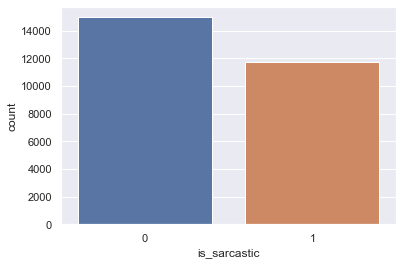

In [4]:
sns.countplot(x=dataset['is_sarcastic'])
plt.show()

Headline de una instancia al azar:

In [5]:
index_random = np.random.randint(0, high = dataset.shape[0])
titular = dataset.iloc[index_random].headline
print(index_random, titular)

22270 former u.s. attorneys warn trump about 'severe repercussions' of firing robert mueller


¿Puede considerarse un texto sarcástico?¿Por qué?

Verificar la etiqueta en el dataset.

In [6]:
print(index_random, dataset.iloc[index_random].is_sarcastic)

22270 0


**NLTK**

Para algunos humanos puede ser difícil detectar el sarcasmo. Probablemente también lo sea para un computador. Sin embargo, se va a intentar la programación. Para ello, se requiere extraer características de cada texto que ayuden al objetivo (identificación). Herramientas:

### Tokenization

Siginifica separar una porción de texto en partes más pequeñas.

¿Cuáles de todas las formas de tokenización presentadas es más útil para este problema?

1. `sent_tokenize`

In [7]:
titular_st = nltk.tokenize.sent_tokenize(titular)
titular_st

["former u.s. attorneys warn trump about 'severe repercussions' of firing robert mueller"]

2. `word_tokenize`

In [8]:
titular_wt = nltk.tokenize.word_tokenize(titular)
titular_wt

['former',
 'u.s.',
 'attorneys',
 'warn',
 'trump',
 'about',
 "'severe",
 'repercussions',
 "'",
 'of',
 'firing',
 'robert',
 'mueller']

### Normalización

Significa estandarizar todas las palabras. Un ejemplo puede ser convertir todas las palabras en mayúsculas o minúsculas. Notar que varias formas de normalización ya vienen aplicadas en el dataset.

1. Stopwords

Son palabras que no tienen un significado por sí solas; modifican o acompañan a otras. Este grupo suele estar conformado por artículos, pronombres, preposiciones, adverbios e incluso algunos verbos.

Importar `stopwords` del inglés e imprimirlos.

In [9]:
# Versión en Español
stopwords = nltk.corpus.stopwords.words('spanish')
stopwords = [palabra for palabra in stopwords if 'not' not in palabra]
stopwords[:10]

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se']

In [10]:
# Versión en Inglés
stopwords = nltk.corpus.stopwords.words('english')
stopwords = [palabra for palabra in stopwords if 'not' not in palabra]
stopwords[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

Del titular elegido en líneas anteriores se eliminan stopwords.

In [11]:
titular_wt_sin_sw = [word for word in titular_wt if word not in stopwords]
titular_wt_sin_sw

['former',
 'u.s.',
 'attorneys',
 'warn',
 'trump',
 "'severe",
 'repercussions',
 "'",
 'firing',
 'robert',
 'mueller']

In [12]:
# Stopwords que se retiraron
list(set(titular_wt) - set(titular_wt_sin_sw))

['of', 'about']

El titular ya está tokenizado por palabras y sin stopwords.

### Frecuencia de palabras

Se usa `nltk` para extrar la frecuencia con que aparece cada palabra.

In [13]:
freq = nltk.FreqDist(titular_wt_sin_sw)
freq

FreqDist({'former': 1, 'u.s.': 1, 'attorneys': 1, 'warn': 1, 'trump': 1, "'severe": 1, 'repercussions': 1, "'": 1, 'firing': 1, 'robert': 1, ...})

### Dataset Completo

Antes de pasar a extraer features de cada instancia del Dataset, se puede hacer un análisis del dataset en su conjunto. Una alternativa es agrupar todos los titulares por tipo y extraer de cada clase las palabras más frecuentes. Para ello:

1. Agrupar los titulares por tipo. Crear un dataframe para cada uno. Usar máscaras.
2. Crear una lista vacia y agregar en esa lista todos los titulares (por tipo/dataframe creado) ya tokenizados (usar el `RegexpTokenizer`) y filtrado por `stopwords`.
3. Usar el `FreqDist` en esa lista que acaban de llenar. Llevar lo que devuelve `FreqDist` a un Dataframe. Ordenar por frecuencia en que aparece cada palabra.
4. Hacer un `barplot` o similar para visualizar.
5. ¿Qué palabras filtrarían, aparte de las que aparecen en `stopwords`? Crear una lista vacía y agregarlas a mano. Agregar en el código que realizaron una línea (similar a la que usan con `stopwords`) para que también filtre por esas palabras.
6. Volver a visualizar.

#### No-Sarcasmo

In [14]:
filtrar = []
if True:
    filtrar.append("u")
    filtrar.append("new")

In [15]:
dataset_no_sarcasmo = dataset[dataset.is_sarcastic == 0]
dataset_no_sarcasmo.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0
5,https://www.huffingtonpost.com/entry/advancing...,advancing the world's women,0
6,https://www.huffingtonpost.com/entry/how-meat-...,the fascinating case for eating lab-grown meat,0


In [16]:
todos_titulares_no_sarcasmo = []

for i in range(dataset_no_sarcasmo.shape[0]):
    titular = dataset_no_sarcasmo.iloc[i].headline #seleccionar el titular
    titular = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(titular) # Tokenizar con RegexpTokenizer
    titular = [word for word in titular if word not in stopwords] # Filtrar por stopwords
    todos_titulares_no_sarcasmo.append(titular) #agregar el resultado a la lista

In [17]:
# Esta celda convierte una lista de listas en una unica lista
todos_titulares_no_sarcasmo = list(itertools.chain(*todos_titulares_no_sarcasmo))
todos_titulares_no_sarcasmo

['former',
 'versace',
 'store',
 'clerk',
 'sues',
 'secret',
 'black',
 'code',
 'minority',
 'shoppers',
 'roseanne',
 'revival',
 'catches',
 'thorny',
 'political',
 'mood',
 'better',
 'worse',
 'j',
 'k',
 'rowling',
 'wishes',
 'snape',
 'happy',
 'birthday',
 'magical',
 'way',
 'advancing',
 'world',
 'women',
 'fascinating',
 'case',
 'eating',
 'lab',
 'grown',
 'meat',
 'ceo',
 'send',
 'kids',
 'school',
 'work',
 'company',
 'friday',
 'morning',
 'email',
 'inside',
 'trump',
 'presser',
 'ages',
 'airline',
 'passengers',
 'tackle',
 'man',
 'rushes',
 'cockpit',
 'bomb',
 'threat',
 'facebook',
 'reportedly',
 'working',
 'healthcare',
 'features',
 'apps',
 'north',
 'korea',
 'praises',
 'trump',
 'urges',
 'us',
 'voters',
 'reject',
 'dull',
 'hillary',
 'actually',
 'cnn',
 'jeffrey',
 'lord',
 'indefensible',
 'barcelona',
 'holds',
 'huge',
 'protest',
 'support',
 'refugees',
 'bloomberg',
 'program',
 'build',
 'better',
 'cities',
 'got',
 'bigger',
 'craig'

In [18]:
#FreqDist
freq_no_sarcasmo = nltk.FreqDist(todos_titulares_no_sarcasmo)
freq_no_sarcasmo

FreqDist({'trump': 1446, 'new': 680, 'donald': 458, 'not': 387, 'says': 349, 'women': 317, 'one': 268, 'u': 263, 'year': 244, 'first': 242, ...})

In [19]:
df_no_sarcasmo = pd.DataFrame(list(freq_no_sarcasmo.items()), columns = ["Word","Frequency"])
df_no_sarcasmo.head()

,Word,Frequency
0,former,82
1,versace,1
2,store,14
3,clerk,5
4,sues,15


In [20]:
# ordenar por frecuencia
df_no_sarcasmo.sort_values('Frequency', ascending = False, inplace = True)
df_no_sarcasmo.head()

,Word,Frequency
46,trump,1446
672,new,680
229,donald,458
498,not,387
421,says,349


In [21]:
df_no_sarcasmo.reset_index(drop = True, inplace=True)
df_no_sarcasmo.head()

,Word,Frequency
0,trump,1446
1,new,680
2,donald,458
3,not,387
4,says,349


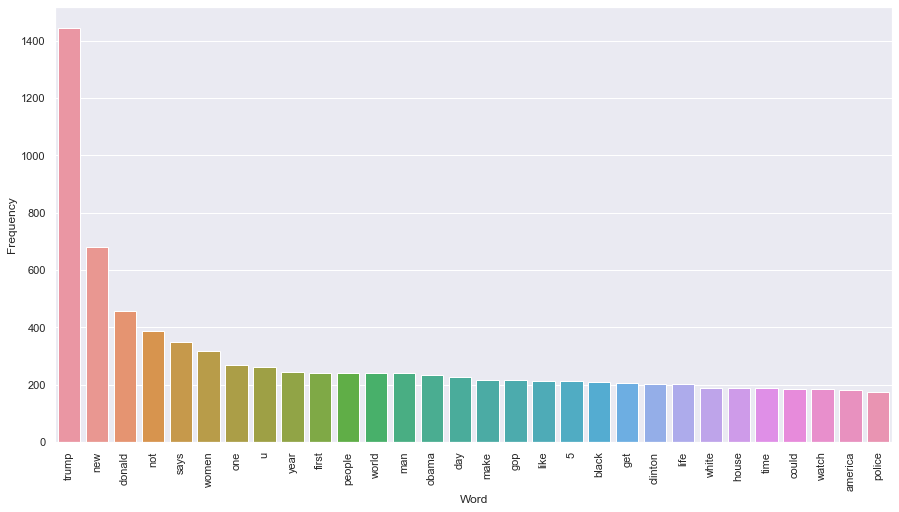

In [22]:
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = df_no_sarcasmo.iloc[:30].Word, y = df_no_sarcasmo.iloc[:30].Frequency)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

#### Sarcasmo

In [23]:
dataset_sarcasmo = dataset[dataset.is_sarcastic == 1]
dataset_sarcasmo.head()

,article_link,headline,is_sarcastic
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
8,https://politics.theonion.com/top-snake-handle...,top snake handler leaves sinking huckabee camp...,1
15,https://entertainment.theonion.com/nuclear-bom...,nuclear bomb detonates during rehearsal for 's...,1
16,https://www.theonion.com/cosby-lawyer-asks-why...,cosby lawyer asks why accusers didn't come for...,1


In [24]:
todos_titulares_sarcasmo = []

for i in range(dataset_sarcasmo.shape[0]):
    titular = dataset_sarcasmo.iloc[i].headline #seleccionar el titular
    titular = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(titular) # Tokenizar con RegexpTokenizer
    titular = [word for word in titular if word not in stopwords] # Filtrar por stopwords
    todos_titulares_sarcasmo.append(titular) #agregar el resultado a la lista

In [25]:
# Esta celda convierte una lista de listas en una unica lista
todos_titulares_sarcasmo = list(itertools.chain(*todos_titulares_sarcasmo))
todos_titulares_sarcasmo

['mom',
 'starting',
 'fear',
 'son',
 'web',
 'series',
 'closest',
 'thing',
 'grandchild',
 'boehner',
 'wants',
 'wife',
 'listen',
 'not',
 'come',
 'alternative',
 'debt',
 'reduction',
 'ideas',
 'top',
 'snake',
 'handler',
 'leaves',
 'sinking',
 'huckabee',
 'campaign',
 'nuclear',
 'bomb',
 'detonates',
 'rehearsal',
 'spider',
 'man',
 'musical',
 'cosby',
 'lawyer',
 'asks',
 'accusers',
 'come',
 'forward',
 'smeared',
 'legal',
 'team',
 'years',
 'ago',
 'stock',
 'analysts',
 'confused',
 'frightened',
 'boar',
 'market',
 'courtroom',
 'sketch',
 'artist',
 'clear',
 'manga',
 'influences',
 'trump',
 'assures',
 'nation',
 'decision',
 'syrian',
 'airstrikes',
 'came',
 'carefully',
 'considering',
 'passing',
 'whims',
 'ex',
 'con',
 'back',
 'behind',
 'bar',
 'careful',
 'consideration',
 'bush',
 'recommends',
 'oil',
 'drilling',
 'giant',
 'altoid',
 'heading',
 'toward',
 'earth',
 'robin',
 'williams',
 'inflicted',
 'holiday',
 'moviegoers',
 'eighth',
 'st

In [26]:
#FreqDist
freq_sarcasmo = nltk.FreqDist(todos_titulares_sarcasmo)
freq_sarcasmo

FreqDist({'man': 1154, 'new': 843, 'area': 480, 'report': 426, 'not': 352, 'nation': 339, 'woman': 319, 'year': 308, 'one': 273, 'old': 267, ...})

In [27]:
df_sarcasmo = pd.DataFrame(list(freq_sarcasmo.items()), columns = ["Word","Frequency"])
df_sarcasmo.head()

,Word,Frequency
0,mom,117
1,starting,32
2,fear,16
3,son,71
4,web,7


In [28]:
# ordenar por frecuencia
df_sarcasmo.sort_values('Frequency', ascending = False, inplace = True)
df_sarcasmo.head()

,Word,Frequency
31,man,1154
126,new,843
184,area,480
159,report,426
13,not,352


In [29]:
df_sarcasmo.reset_index(drop = True, inplace=True)
df_sarcasmo.head()

,Word,Frequency
0,man,1154
1,new,843
2,area,480
3,report,426
4,not,352


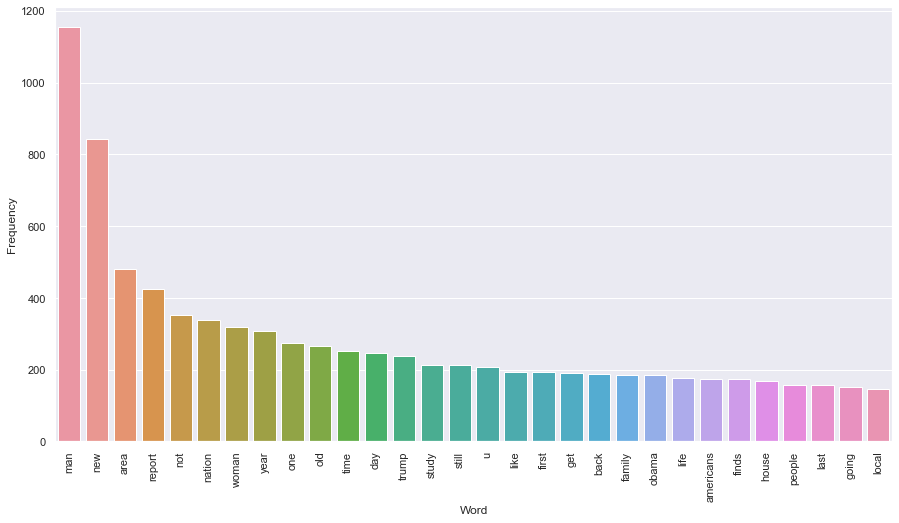

In [30]:
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = df_sarcasmo.iloc[:30].Word, y = df_sarcasmo.iloc[:30].Frequency)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

## Stemming

Por razones gramaticales muchas palabras pueden escribirse de manera distinta (debido a conjugación, género, número) pero tienen el mismo significado para el texto. Por ejemplo: "jugar", "jugando" o "juega" son conjugaciones que el computador puede tomar como palabras distintas. Sin embargo en términos de significado, todas relacionan al verbo Jugar. Muchas veces es útil unir todas estos términos en uno solo.

Una forma de hacer esto es por "STEMMING", que es un proceso eurístico que recorta la terminación de las palabras, agrupándolas por su raiz.

Importar nuevamente el dataset completo

In [3]:
dataset = dataset = pd.read_json ("Sarcasm_Headlines_Dataset.json", lines = True)
dataset.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


Tomar del dataset las columnas de interés

In [4]:
dataset.dropna(axis=0,inplace=True)  # Si hay alguna nan, tiramos esa instancia
dataset.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [5]:
# Features y etiquetas (variables predictoras y variable a predecir)
features = dataset['headline']
labels = dataset['is_sarcastic']

In [6]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
# Haciendo Stemming
ps = PorterStemmer()
features = features.apply(lambda x: x.split())
features = features.apply(lambda x : ' '.join([ps.stem(word) for word in x]))

## Lemmatization

Otra manera de llevar distintas palabras a un raíz común en la que comparten un significado es mediante el procezo de 'Lemmatizar' el texto. Es similar al 'Stemming' pero un poco más elaborado, ya que intenta realizar el proceso teniendo en cuenta cuál es el rol que la palabra cumple en el texto. Esto quiere decir que el outcome será distinto si la palabra a lemmatizar está actuando como verbo, sustantivo, etc. 

Nota: En caso de querer usar las funciones que ofrece `nltk` para lemmatizar, sería necesario que descargar la libreria `Wordnet` y las librerias 'maxent_treebank_pos_' y 'averaged_perceptron_tagger'. También considerar que Hay distintos metodos que intentan averiguar el rol que cumple una palabra en una oración, uno de ellos que está incorporado en NLTK es pos_tag.

## Vectorizar

Hasta ahora se tiene un grupo de palabras por cada titular (bag of words), ya sea *lemmatizado* o *stemmizado*. La idea ahora es representar esta lista de palabras como un vector. Una de las funciones que se permite realizar esto es `CountVectorizer` de Scikit-Learn. Esta función permite representar cada título por un vector con un `1` en las palabras que contiene y un `0` en las que no. Acá se usará `TfidfVectorizer` (Term Frequency Inverse Document Frequency) que permite transformar texto en representaciones numéricas.

In [7]:
# Vectorizar los datos con un max de 5000 features
from sklearn.feature_extraction.text import TfidfVectorizer
tv = TfidfVectorizer(max_features = 5000)
features = list(features)
features = tv.fit_transform(features).toarray()

In [8]:
from sklearn.model_selection import train_test_split
# Separación de los datos
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = .05, random_state = 0)

In [10]:
# Instanciar modelo
# Entrenar modelo
# Predecir y Evaluar (en train y test)

from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Modelo 1: linear support vector classifier
lsvc = LinearSVC()
lsvc.fit(features_train, labels_train)
print(lsvc.score(features_train, labels_train))
print(lsvc.score(features_test, labels_test))
# Modelo 2: Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(features_train, labels_train)
print(gnb.score(features_train, labels_train))
print(gnb.score(features_test, labels_test))
# Modelo 3: Regresión Logística Logistic Regression
lr = LogisticRegression()
lr.fit(features_train, labels_train)
print(lr.score(features_train, labels_train))
print(lr.score(features_test, labels_test))
# Modelo 4: Random Forest Classifier
rfc = RandomForestClassifier(n_estimators = 10, random_state = 0)
rfc.fit(features_train, labels_train)
print(rfc.score(features_train, labels_train))
print(rfc.score(features_test, labels_test))

0.9107712923186064
0.8255988023952096
0.7826823789067119
0.7462574850299402
0.8829858511015647
0.8345808383233533
0.9892011193000434
0.7971556886227545


**Bonus:** ejemplo completo con el mismo dataset para un modelo de Árbol de decisión.

In [1]:
import itertools

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import nltk

In [2]:
dataset = dataset = pd.read_json ("Sarcasm_Headlines_Dataset.json", lines = True)
dataset.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


In [4]:
dataset.dtypes

article_link    object
headline        object
is_sarcastic     int64
dtype: object

In [5]:
dataset.shape

(26709, 3)

In [6]:
dataset.is_sarcastic.unique()

array([0, 1], dtype=int64)

In [7]:
dataset.describe()

,is_sarcastic
count,26709.000000
mean,0.438953
std,0.496269
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [8]:
dataset.is_sarcastic.value_counts()

0    14985
1    11724
Name: is_sarcastic, dtype: int64

In [9]:
dataset['source'] = dataset.article_link.apply(lambda x: x.split('.')[1])
dataset = dataset.drop('article_link', axis=1)
dataset.shape

(26709, 3)

In [10]:
dataset.head()

,headline,is_sarcastic,source
0,former versace store clerk sues over secret 'b...,0,huffingtonpost
1,the 'roseanne' revival catches up to our thorn...,0,huffingtonpost
2,mom starting to fear son's web series closest ...,1,theonion
3,"boehner just wants wife to listen, not come up...",1,theonion
4,j.k. rowling wishes snape happy birthday in th...,0,huffingtonpost


In [11]:
dataset.source.unique()

array(['huffingtonpost', 'theonion'], dtype=object)

Se puede decir que la columna is_sarcastic está bien balanceada y no tiene nulos.

In [12]:
dataset.source.value_counts()

huffingtonpost    14985
theonion          11724
Name: source, dtype: int64

In [13]:
all_words = dataset['headline'].str.split(expand=True).unstack().value_counts()

In [14]:
all=pd.DataFrame(all_words).reset_index()

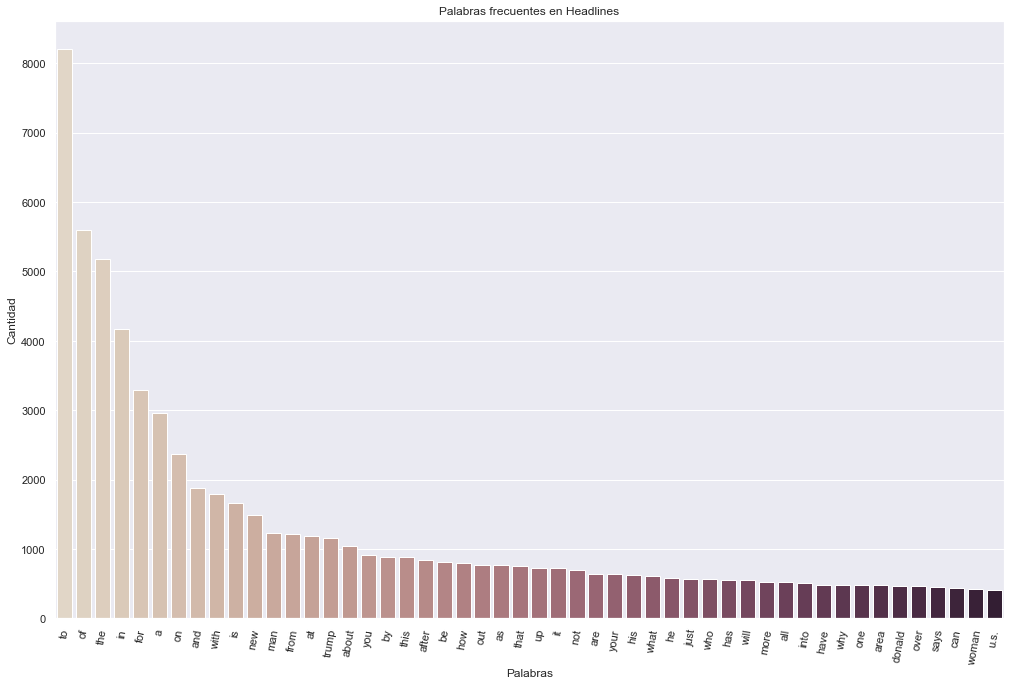

In [15]:
sns.set(rc={'figure.figsize':(17,11)})
sns.barplot(x=all['index'][0:50], y=all[0][0:50], data=all,palette="ch:.25")
plt.xlabel('Palabras')  # Add an x-label to the axes.
plt.ylabel('Cantidad')  # Add a y-label to the axes.
plt.title("Palabras frecuentes en Headlines") 
plt.xticks(rotation=80);

In [16]:
all_words = dataset['headline'].str.split(expand=True).unstack().value_counts()

In [17]:
non_sarc=pd.DataFrame(dataset[dataset['is_sarcastic']==0]['headline'].str.split(expand=True).unstack().value_counts()).reset_index()

In [18]:
sarc=pd.DataFrame(dataset[dataset['is_sarcastic']==1]['headline'].str.split(expand=True).unstack().value_counts()).reset_index()

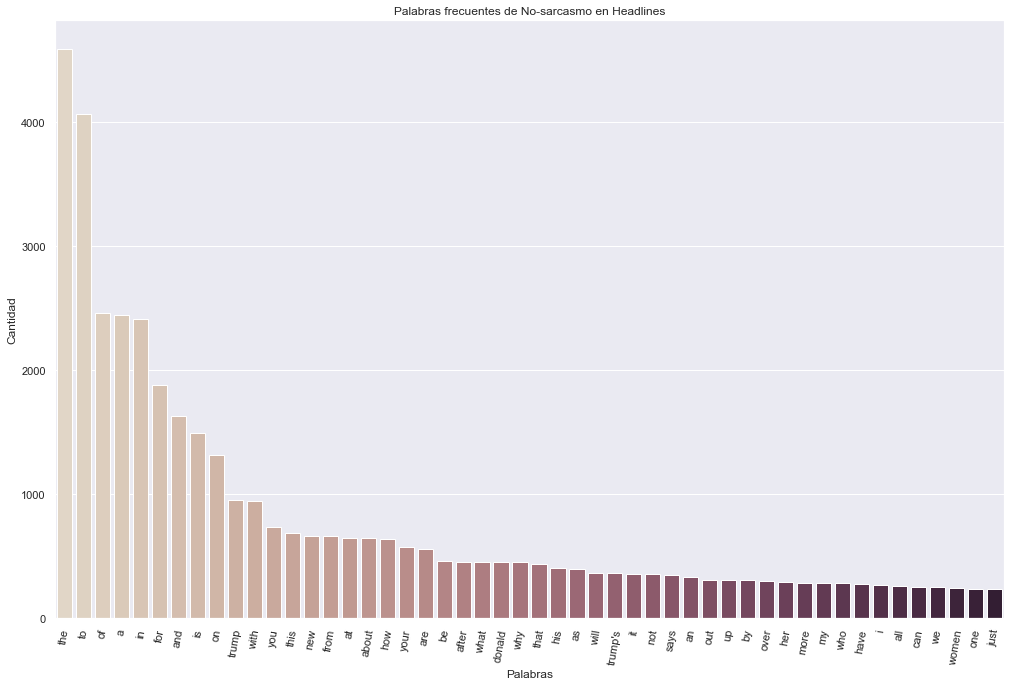

In [19]:
sns.set(rc={'figure.figsize':(17,11)})
sns.barplot(x=non_sarc['index'][0:50], y=non_sarc[0][0:50], data=non_sarc,palette="ch:.25")
plt.xlabel('Palabras')  # Add an x-label to the axes.
plt.ylabel('Cantidad')  # Add a y-label to the axes.
plt.title("Palabras frecuentes de No-sarcasmo en Headlines") 
plt.xticks(rotation=80);

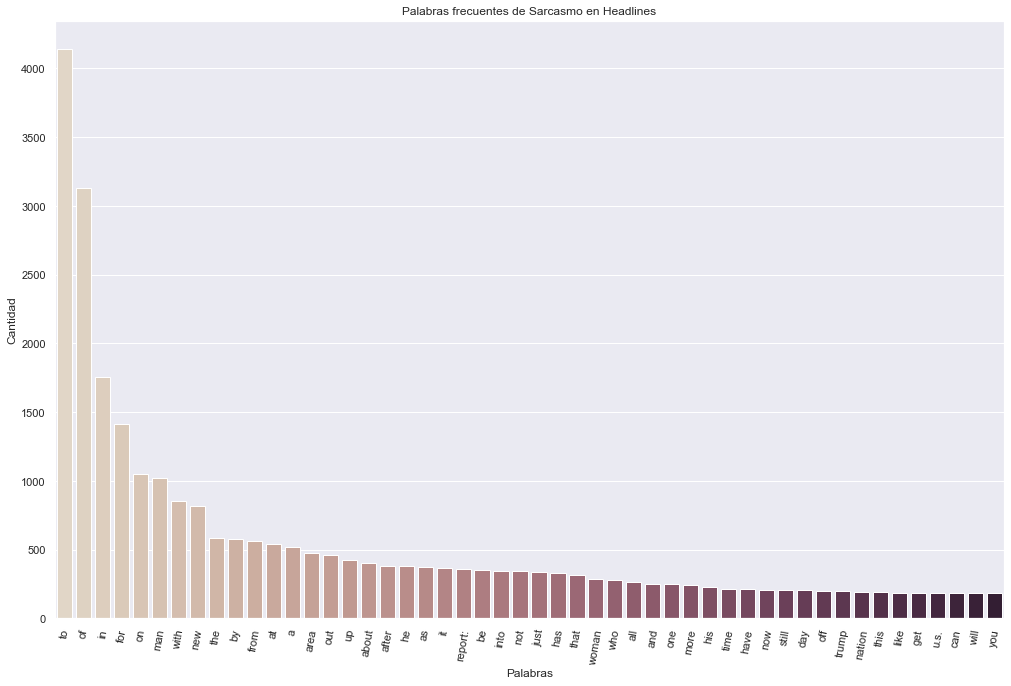

In [20]:
sns.set(rc={'figure.figsize':(17,11)})
sns.barplot(x=sarc['index'][0:50], y=sarc[0][0:50], data=sarc,palette="ch:.25")
plt.xlabel('Palabras')  # Add an x-label to the axes.
plt.ylabel('Cantidad')  # Add a y-label to the axes.
plt.title("Palabras frecuentes de Sarcasmo en Headlines") 
plt.xticks(rotation=80);

Otra forma de obtener las palabras

In [21]:
import nltk
nltk.download('stopwords')
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [22]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [23]:
from nltk.corpus import wordnet

In [24]:
sar_tokens = dataset[dataset['is_sarcastic'] == 1]['headline'].apply(lambda x: nltk.word_tokenize(x))  #don't like it because of "'s'" and so on

In [25]:
nonsar_tokens = dataset[dataset['is_sarcastic'] == 0]['headline'].apply(lambda x: nltk.word_tokenize(x))

Retiro de Stopwords

In [26]:
stopwords = nltk.corpus.stopwords.words('english')

In [27]:
sarc2=[each_word.lower() for each_word in sarc['index']] #lowcase

In [28]:
sarc_nostop = [word for word in sarc2 if word not in stopwords]

In [29]:
non_sarc2=[each_word.lower() for each_word in non_sarc['index']]

In [30]:
non_sarc_nostop = [word for word in non_sarc2 if word not in stopwords]

Visualización con WordCloud

In [31]:
from wordcloud import WordCloud, ImageColorGenerator

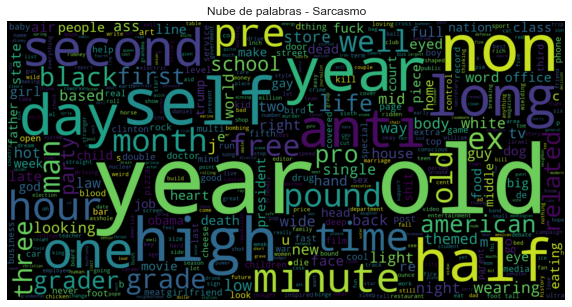

In [32]:
plt.figure(figsize = (10,10))
wc = WordCloud(width = 2000 , height = 1000 , max_words = 500).generate(' '.join(word for word in sarc_nostop))
plt.axis("off")
plt.title('Nube de palabras - Sarcasmo')
plt.imshow(wc , interpolation = 'bilinear')

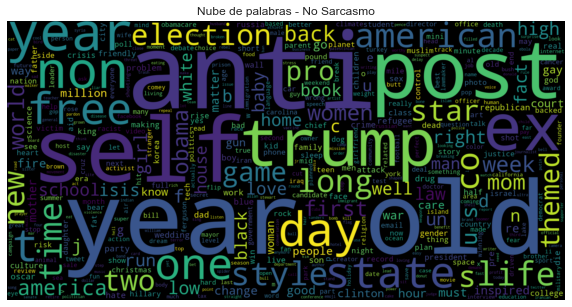

In [33]:
plt.figure(figsize = (10,10))
wc = WordCloud(width = 2000 , height = 1000 , max_words = 500).generate(' '.join(word for word in non_sarc_nostop))
plt.axis("off")
plt.title('Nube de palabras - No Sarcasmo')
plt.imshow(wc , interpolation = 'bilinear')

Comparación del largo de los headlines de sarcasmo y no-sarcasmo

In [34]:
dataset['text_len'] = dataset['headline'].apply(lambda x: len(x.split(' ')))

In [35]:
dataset[dataset['text_len']>30]

,headline,is_sarcastic,source,text_len
15247,"elmore leonard, modern prose master, noted for...",1,theonion,39
17306,"'12 years a slave,' 'captain phillips,' 'ameri...",1,theonion,31
21783,occasionally you realize someone you thought w...,0,huffingtonpost,38
23473,"something to vote for on november 8, 2016: ...",0,huffingtonpost,34


In [36]:
dataset['headline'][23473]

'something to vote for on november 8, 2016:          elect 279 candidates on election day and the united states leads the world in fighting climate change!'

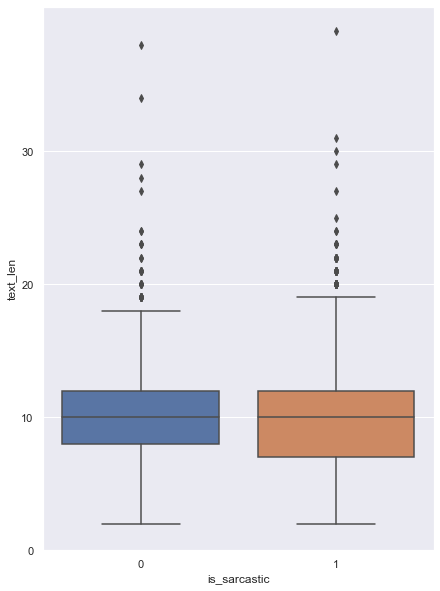

In [37]:
plt.figure(figsize = (7 ,10))
sns.boxplot(y='text_len', x="is_sarcastic", data=dataset)
y=dataset['text_len']
plt.yticks(np.arange(0, max(y), 10));

No-sarcasmo headlines parece ser que son más parejos en su longitud. Los que son de sarcasmo tienden a ser más largos.

**Preparación de datos**

Retiro de stopwords y caracteres que no son alfanuméricos.

In [38]:
import re
def parser(x):
    x = re.sub('[^a-z\s]', '', x.lower())  #Retirar cualquier símbolo excepto caracteres a-z
    x = [w for w in x.split() if w not in set(stopwords)]
    x = [w for w in x if wordnet.synsets(w)]
    return ' '.join(x)

dataset['headline'] = dataset.headline.apply(lambda x: parser(x))

In [39]:
X = dataset['headline']
y = dataset.is_sarcastic

In [40]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0)

In [41]:
from sklearn.feature_extraction.text import CountVectorizer

In [42]:
cv = CountVectorizer(ngram_range=(1,3))
X_cv_train = cv.fit_transform(X_train)
X_cv_test = cv.transform(X_test)

In [43]:
from sklearn.tree import DecisionTreeClassifier

In [44]:
tree_model = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=1)
tree_model.fit(X_cv_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=1)

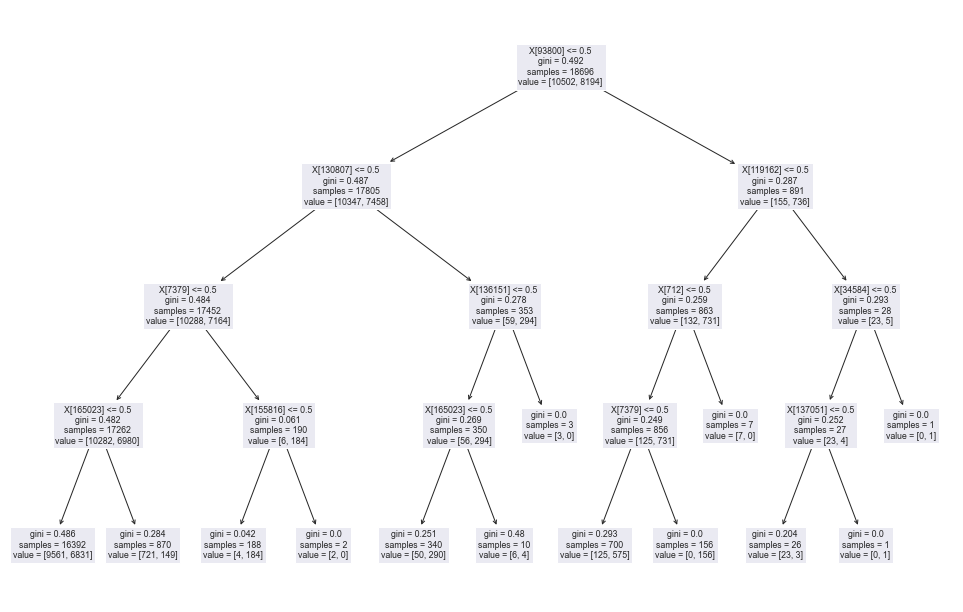

In [45]:
from sklearn import tree
tree.plot_tree(tree_model)
plt.savefig('hey.pdf')
plt.show()

In [46]:
from sklearn.metrics import confusion_matrix, classification_report

In [47]:
y_pred = tree_model.predict(X_cv_test)
test = np.array(y_test)
predictions = np.array(y_pred)
confusion_matrix(test, predictions)

array([[4399,   84],
       [3051,  479]], dtype=int64)

In [48]:
from sklearn.metrics import accuracy_score, f1_score

In [49]:
print('accuracy:', accuracy_score(y_test,y_pred))
print('f1-score:', f1_score(y_test,y_pred))

accuracy: 0.6087607637588918
f1-score: 0.23405814805765943


In [50]:
acc_tree = accuracy_score(y_test,y_pred)
acc_tree

0.6087607637588918